# Project 1: Regression and Shrinkage

# Part 1

In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

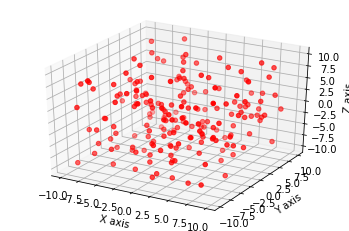

In [2]:
# generating x_i
x1 = np.random.uniform(low=-10,high=10,size=200)
x2 = np.random.uniform(low=-10,high=10,size=200)
x3 = np.random.uniform(low=-10,high=10,size=200)
x = np.array([x1,x2,x3])
# Plotting
fig = plt.figure()
ax = fig.add_subplot(111,projection="3d")
ax.scatter(x[0],x[1],x[2],c='r')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()

In [3]:
# shuffle the data for picking up training and testing data
# this X.T is 200 rows and 3 columns
np.random.shuffle(x.T)
# setting up other parameters
w = np.array([-0.8, 2.1, 1.5])[None]
b = 10
# loc=>mean scale=>standard diviation
eps = np.random.normal(loc=0, scale=np.sqrt(10) ,size=200)
# adding noise
y = np.dot(w,x)+b+eps

# splitting data into two parts
x_train = x.T[0:100] # its shape is (100,3)
x_test  = x.T[100:200]
# spliting y
y_train = y.T[0:100] # its shape is (100,1)
y_test  = y.T[100:200]

# Part 2 Rigid Regression

In [4]:
# standardizing test and training data
x_train = (x_train-np.mean(x_train))/np.std(x_train)
# y_train = (y_train-np.mean(y_train))/np.std(y_train)
x_test = (x_test-np.mean(x_test))/np.std(x_test)
# y_test = (y_test-np.mean(y_test))/np.std(y_test)
x_train.shape, y_train.shape, len(x_train.T)

((100, 3), (100, 1), 3)

In [5]:
# setting up the lambda test array
lambda_array = np.arange(0,10,0.1)

def rigid_regression(x_train, y_train, _lambda):
    ones    = np.ones(len(x_train))[None].T
    x_train = np.column_stack((ones, x_train))
    
    lambda_identity = _lambda*np.identity(len(x_train.T))
    the_inverse     = np.linalg.inv(np.dot(x_train.T,x_train) + lambda_identity)
    w_hat           = np.dot(np.dot(the_inverse, x_train.T),y_train)
    
    return w_hat

In [6]:
# Apply Rigid Regression
w_hat = []
for i in lambda_array:
    w_temp = rigid_regression(x_train,y_train,i)[None]
    w_hat = np.append(w_hat, w_temp.T)

w_hat = w_hat.reshape(len(lambda_array),4) # reshaping

# print(w_hat.shape)           
b_hat = w_hat[:,0]
w_hat = np.delete(w_hat,0,1).T
w_hat.shape, x_test.shape

((3, 100), (100, 3))

In [7]:
# Calculate estimation of y
y_hat = np.empty((100,100))
for i in range(100):
    y_hat[i] = np.dot(w_hat.T[i], x_test.T) + b_hat

# y_hat = np.dot(w_hat.T, x_test.T) + b_hat
# y_hat = np.dot(x_test, w_hat) + b_hat

# y_hat.shape,np.dot(w_hat.T, x_test.T).shape
# y_hat[0] for the first lambda
y_test.shape, y_hat.shape

((100, 1), (100, 100))

In [8]:
# Calculate SSE
sse = np.zeros((100,1))
for i in range(100):
    sse[i] = np.sum(np.power((y_test.T-y_hat[i]),2))

sse = np.sum(sse,axis=1)
sse.shape

(100,)

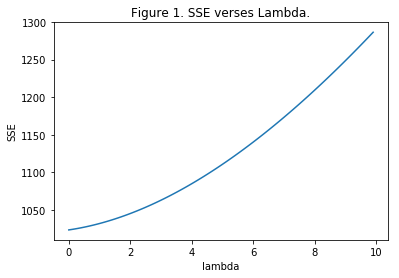

In [9]:
# First plot
# Plotting SSE verses lambda
figure1 = plt.figure()
plot1   = figure1.add_subplot(111)
plot1.set_title("Figure 1. SSE verses Lambda.")
plot1.plot(lambda_array, sse)
plt.xlabel("lambda")
plt.ylabel("SSE")
plt.show()

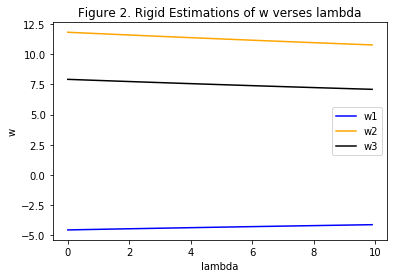

In [71]:
# Second plot
# plotting w verses lambda
figure2 = plt.figure()
plot2   = figure2.add_subplot(111)
plot2.set_title("Figure 2. Rigid Estimations of w verses lambda")
plot2.plot(lambda_array, w_hat[0],c="blue", label="w1")
plot2.plot(lambda_array, w_hat[1],c="orange", label="w2")
plot2.plot(lambda_array, w_hat[2],c="black", label="w3")
plt.legend()
plt.xlabel("lambda")
plt.ylabel("w")
plt.show()

In [11]:
print("The estimation of b is ",np.mean(b_hat))

The estimation of b is  8.701485953235506


# Problem 3: LASSO Regression

In [74]:
def ols(x_train,y_train):
    # adding a column of ones to x_train
    ones        = np.ones(len(x_train))[None].T
    x_train     = np.column_stack((ones, x_train))
    # appling OLS to the training data
    the_inverse = np.linalg.inv(np.dot(x_train.T,x_train))
    temp_w      = np.dot(np.dot(the_inverse, x_train.T), y_train)
    
    return temp_w
    
temp_w    = ols(x_train,y_train)
bias      = temp_w[0]
initial_w = np.delete(temp_w,0,0)
# initial_w.shape, temp_w
print("The bias is ",bias)

The bias is  [9.1398362]


In [63]:
from cvxopt import matrix, solvers
solvers.options['show_progress'] = False

def lasso_regression(init_w, x, y,_lambda):
    w_est    = init_w
    Ge       = np.sign(w_est)
    first_it = True
    while(sum(np.abs(w_est))>=(1/_lambda)):
        if (first_it):
            first_it = False
            # defining H and f matrix from "Standard Form"
            H     = matrix(2*np.dot(x_train.T, x_train))      # 3x3
            f     = matrix(-2*np.dot(x_train.T, y_train))     # 3x1
            A     = matrix(np.sign(initial_w.T))
            h     = matrix((1/_lambda)*np.ones(len(Ge.T)))
            sol   = solvers.qp(H,f,A,h)
            w_est = sol['x']
        else:
            Ge = np.hstack((Ge, np.sign(w_est)))
            # defining H and f matrix from "Standard Form"
            H     = matrix(2*np.dot(x_train.T, x_train))      # 3x3
            f     = matrix(-2*np.dot(x_train.T, y_train))     # 3x1
            A     = matrix(Ge.T)
            h     = matrix((1/_lambda)*np.ones(len(Ge.T)))
            sol   = solvers.qp(H,f,A,h)
            w_est = np.array(sol['x'])
        
    return w_est

# setting up the lambda test array
lam = np.arange(0.1,10.1,0.1)
lam_plot = np.arange(0.1,10.2,0.1)
ans = initial_w
for item in lam:
    # x:100x3   y:100x1    initial_w:3x1
    temp_ans = lasso_regression(initial_w, x_train, y_train, item)
    ans = np.append(ans,temp_ans)
print("Regression Completed!")

Regression Completed!


Text(0.5, 1.0, 'Figure 3. Lasso Estimations of w verses lambda')

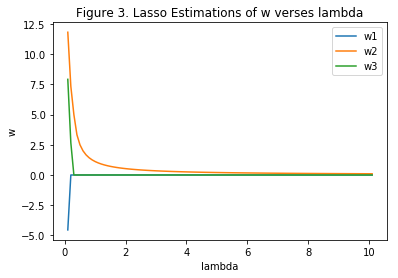

In [73]:
# r = np.append(initial_w.T, ans)
ss = ans.reshape(101,3)
fig = plt.figure()
pl = fig.add_subplot(111)
pl.plot(lam_plot,ss[:,0],label="w1")
pl.plot(lam_plot,ss[:,1],label="w2")
pl.plot(lam_plot,ss[:,2],label="w3")
pl.legend()
plt.xlabel("lambda")
plt.ylabel("w")
plt.title("Figure 3. Lasso Estimations of w verses lambda")